In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['SimHei']
matplotlib.rcParams['axes.unicode_minus'] = False

In [53]:
n_repeat = 100 # 训练的轮数
n_train = 50  # 训练样本点的数量
n_test = 500   
noise = 0.15  # 基于正态分布噪音的标准差 
np.random.seed(0)

estimators = [("Tree", DecisionTreeRegressor()),
              ("Bagging(Tree)", BaggingRegressor(DecisionTreeRegressor())),
              ("Adaboost(tree)", AdaBoostRegressor(DecisionTreeRegressor()))]
              

n_estimators = len(estimators)


# Generate data
def f(x):
    x = x.ravel()

    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise, n_repeat=1):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X) # X.shape=(n_samples, )

    if n_repeat == 1:
        y = f(X) + np.random.normal(0.0, noise, n_samples) # y.shape = (n_samples,)
    else:
        y = np.zeros((n_samples, n_repeat)) # y.shape=(n_samples, n_repeat)

        for i in range(n_repeat):
            y[:, i] = f(X) + np.random.normal(0.0, noise, n_samples) # 生成n_repreat条(列)数据

    X = X.reshape((n_samples, 1))

    return X, y

X_train = []
y_train = []

# 生成n_repeat轮用于训练的数据集
for i in range(n_repeat):
    X, y = generate(n_samples=n_train, noise=noise)
    X_train.append(X)
    y_train.append(y)

# 生成n_repeat轮用于测试的数据集
X_test, y_test = generate(n_samples=n_test, noise=noise, n_repeat=n_repeat)

Tree: 0.0497 (error) = 0.0003 (bias^2)  + 0.0269 (var) + 0.0222 (noise)
Bagging(Tree): 0.0390 (error) = 0.0006 (bias^2)  + 0.0159 (var) + 0.0222 (noise)
Adaboost(tree): 0.0493 (error) = 0.0004 (bias^2)  + 0.0264 (var) + 0.0222 (noise)


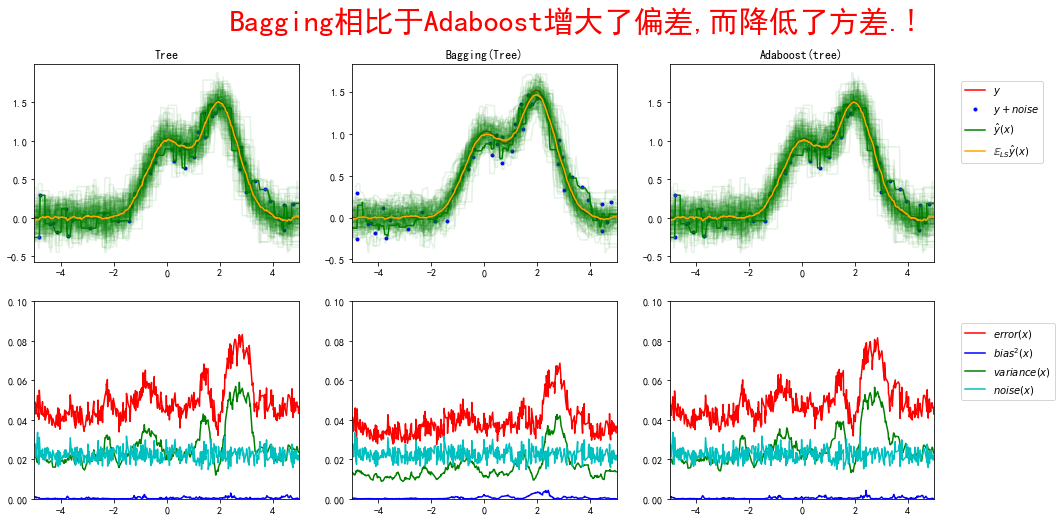

In [54]:
figure = plt.figure(figsize=(20, 8))

for n, (name, estimator) in enumerate(estimators):
    y_predict = np.zeros((n_test, n_repeat))
    for i in range(n_repeat):
        estimator.fit(X_train[i], y_train[i])
        y_predict[:, i] = estimator.predict(X_test) # 根据X_train[i], y_train[i]预测y_predict[:, i]       
    y_error = np.zeros(n_test)
    for i in range(n_repeat):
        for j in range(n_repeat):
            y_error += (y_test[:, j] - y_predict[:, i]) ** 2
    y_error /= (n_repeat * n_repeat) # 泛化误差
    
    y_noise = np.var(y_test, axis=1) # 噪音
    y_bias = (f(X_test) - np.mean(y_predict, axis=1)) ** 2 # 偏差(期望输出与真实标记的差)
    y_var = np.var(y_predict, axis=1) # 方差
    
    # 泛化误差=偏差+噪音+方差
    print("{0}: {1:.4f} (error) = {2:.4f} (bias^2) "
          " + {3:.4f} (var) + {4:.4f} (noise)".format(name,
                                                      np.mean(y_error),
                                                      np.mean(y_bias),
                                                      np.mean(y_var),
                                                      np.mean(y_noise)))

    # Plot figures
    plt.subplot(2, n_estimators, n + 1)
    plt.plot(X_test, f(X_test), "r", label="$y$") # 真实曲线 
    plt.plot(X_train[0], y_train[0], ".b", label="$y+noise$") # 第一条生成的数据(=真实值+noise)

    for i in range(n_repeat):
        """所有数据的预测值"""
        if i == 0:
            plt.plot(X_test, y_predict[:, i], "g", label=r"$\^y(x)$")
        else:
            plt.plot(X_test, y_predict[:, i], "g", alpha=0.1)

    plt.plot(X_test, np.mean(y_predict, axis=1), "orange",
             label=r"$\mathbb{E}_{LS} \^y(x)$") # 最终学习到的曲线

    plt.xlim([-5, 5])
    plt.title(name)

    if n == n_estimators - 1:
        plt.legend(loc=(1.1, .5))

    plt.subplot(2, n_estimators, n_estimators + n + 1)
    plt.plot(X_test, y_error, "r", label="$error(x)$")
    plt.plot(X_test, y_bias, "b", label="$bias^2(x)$"),
    plt.plot(X_test, y_var, "g", label="$variance(x)$"),
    plt.plot(X_test, y_noise, "c", label="$noise(x)$")

    plt.xlim([-5, 5])
    plt.ylim([0, 0.1])

    if n == n_estimators - 1:

        plt.legend(loc=(1.1, .5))

plt.suptitle('Bagging相比于Adaboost增大了偏差,而降低了方差.!', size=30, color='red')
plt.subplots_adjust(right=.75)
plt.show()